In [1]:
#load packages
import os, sys, cv2, re, itertools,time
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate as integrate
from PyQt5 import QtWidgets, QtGui
from PyQt5.uic import loadUi
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import image
from keras.utils import plot_model
from keras.utils import to_categorical
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
from customised_functions import *

In [3]:
#Data preparation

##load dataframe prepared 
train_folder = "C:/Users/folia/metar_project/images/filtered/filtered_train_cropped"
df = pd.read_excel("C:/Users/folia/metar_project/images/filtered/filtered_train_cropped/filtered_train.xlsx")
df = df.sample(frac=1) #random shuffle for dataframe, just to cut off smilarities between "windows" and let model learn more complex patterns

#First, visualise ROI and non-ROI images in 3D plot to see if they are seperatable.
img_list_train = []       #create a list of image arrays
img_avg_list = []   #create a list of averaged BGR channel values.

#Read images into an array, and calculate mean value of every channel of each photo
for name in df['window_name']:
    #Read images
    temp = cv2.imread(os.path.join(train_folder, name))
    img_list_train.append(temp)
    
    #Calculate average values of single channel of each photo
    avgB = np.mean(temp[:,:,0]).round(1)
    avgG = np.mean(temp[:,:,1]).round(1)
    avgR = np.mean(temp[:,:,2]).round(1)
    img_avg_list.append([avgB,avgG,avgR])

img_list_train = np.array(img_list_train,dtype="float32")/255.0    
del temp

#create mask to distinguish ROI or non-ROI images
maskY = df['is_ROI'] == "Y"
maskN = df['is_ROI'] == "N"

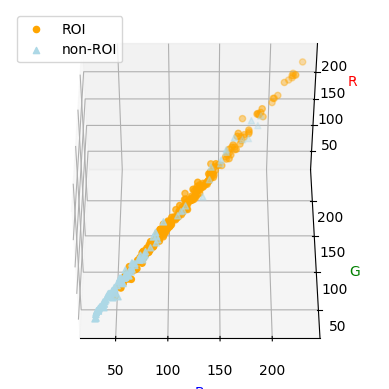

'Using average values of each BGR channels, one can see the distribution of two group is different. \nThe difference may be arise from the use of IR-filter (whick blocks light with wavelength <680nm).\nThis shed a light on using SVM for classifying images into ROI and non-ROI group.\nHowever, the information contained in the avg values is not enough for seperating them, original info. will be used instead of avg. values.'

In [4]:
#Plot avg values of averaged BGR channel values of images

#Create 3D figure
fig = plt.figure()
ax = plt.axes(projection='3d')

#Divide into ROI or non-ROI groups
groupY = np.array(img_avg_list)[maskY]
groupN = np.array(img_avg_list)[maskN]

# Scatter plot for group ROI
ax.scatter(groupY[:, 0], groupY[:, 1], groupY[:, 2], c='orange', marker='o', label='ROI')

# Scatter plot for group non-ROI
ax.scatter(groupN[:, 0], groupN[:, 1], groupN[:, 2], c='lightblue', marker='^', label='non-ROI')

#Adjust viewing angle
ax.view_init(elev=45, azim=270)  # ele = angle of vertical angle, azim = angle of x-y plane

#Set labels
ax.set_xlabel('B').set_color('Blue')
ax.set_ylabel('G').set_color('Green')
ax.set_zlabel('R').set_color('Red')

# Add a legend
ax.legend()

# Show the plot
plt.show()

'''Using average values of each BGR channels, one can see the distribution of two group is different. 
The difference may be arise from the use of IR-filter (whick blocks light with wavelength <680nm).
This shed a light on using SVM for classifying images into ROI and non-ROI group.
However, the information contained in the avg values is not enough for seperating them, original info. will be used instead of avg. values.'''

In [5]:
#SVM model for binary image classification

#Prepare data source
L = img_list_train.shape[0]
img_list_train_svm = img_list_train.reshape(L,-1) #One shape dimension can be -1. This is to flatten images

#Build and train SVM model. Polynomil kernel functions has the best performence on this dataset.
svm_poly = svm.SVC(kernel='poly')
svm_poly.fit(img_list_train_svm, df['is_ROI'])

SVC(kernel='poly')

In [6]:
#Examinate model performence

#Accuracy
svm_poly.score(img_list_train_svm,df['is_ROI'])  #Accuracy 92%

#Confusion Matrix
classes = ["Y","N"]
pred = svm_poly.predict(img_list_train_svm)
cm = confusion_matrix(df['is_ROI'],pred,labels =classes) #set order of classes Y -> N for readibility
print('Confusion Matrix', "\n",cm)

Confusion Matrix 
 [[229  18]
 [  7  86]]


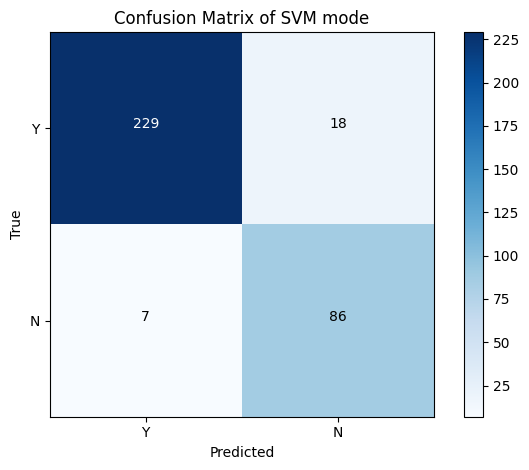

In [7]:
#Visualise comfusion matrix in heatmap form
#Add data
plt.imshow(cm, interpolation = "nearest", cmap = plt.cm.Blues)

#Add legend
plt.title("Confusion Matrix of SVM mode")
plt.colorbar()
ticks = np.arange(len(classes)) #take unique values, and then set sequence number
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j]),horizontalalignment="center",
                 color="white" if cm[i, j] >  cm.max()/2 else "black")
                 #plt.text() in col-row order, inverse of cm, thus input j, i    
plt.ylabel('True')
plt.xlabel('Predicted')

#Plot out
plt.tight_layout()

In [8]:
#Examinate the model trained on test data

#Folder path
df_test = pd.read_excel("C:/Users/folia/metar_project/images/filtered/filtered_test_cropped/filtered_test.xlsx")
test_folder = "C:/Users/folia/metar_project/images/filtered/filtered_test_cropped"

#Load images
img_list_test = []
for name in df_test['window_name']:
    temp = cv2.imread(os.path.join(test_folder, name))
    img_list_test.append(temp)

img_list_test = np.array(img_list_test,dtype="float32")/255.0    
del temp

#Load labels
label_list_test = df_test["is_ROI"]

#Flatten data
L = img_list_test.shape[0]
img_list_test_svm = img_list_test.reshape(L,-1)

#Check accuracy
svm_poly.score(img_list_test_svm,df_test["is_ROI"])

0.7640449438202247

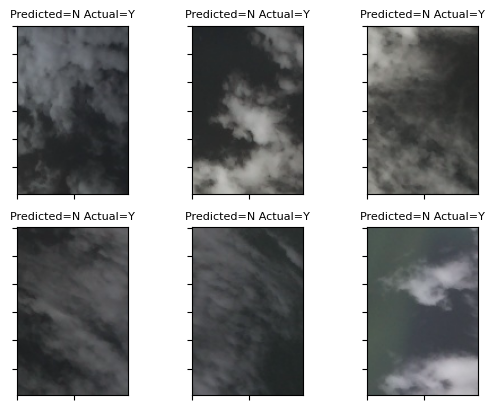

'\nOn test dataset, the accuracy is approximately 75%.\nFirst, check the original data. \nTest label list has 57% of Y, 43% of N, by which we can say that the SVM model perform well over naive guess,\nand orginal Y/N distribution seems has no effect on prediction. \nHowever, it takes too long on predicting computation.\n\nAfter examining the images below, two interim conclusion were made, as following.\n1. It seems that the SVM model performs well on pattern recognition, some falsely marked (by me) were pick out.\n2. Edge of clouds is likely to be falsely recognised (Ex: the first image on left upper corner).\n'

In [9]:
#Make predictions and inspect results

start_time = time.time()
#Make prediction
df_test['is_ROI_pred'] = svm_poly.predict(img_list_test_svm)
end_time = time.time()
t_diff1 = end_time-start_time

#Check images of unmatched predictions
mask = df_test['is_ROI'] != df_test['is_ROI_pred']
temp = df_test[mask]
index = temp.index #index of df was shuffled, thus need an extra index

for i in range(6):
    img = cv2.imread(os.path.join(test_folder,temp['window_name'][index[i]]))
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title("Predicted=" + temp['is_ROI_pred'][index[i]] + " Actual=" + temp['is_ROI'][index[i]],fontsize=8)
    plt.xticks(visible = False)
    plt.yticks(visible = False)
plt.show()
del temp
'''
On test dataset, the accuracy is approximately 75%.
First, check the original data. 
Test label list has 57% of Y, 43% of N, by which we can say that the SVM model perform well over naive guess,
and orginal Y/N distribution seems has no effect on prediction. 
However, it takes too long on predicting computation.

After examining the images below, two interim conclusion were made, as following.
1. It seems that the SVM model performs well on pattern recognition, some falsely marked (by me) were pick out.
2. Edge of clouds is likely to be falsely recognised (Ex: the first image on left upper corner).
'''

In [10]:
#Use SVM precition to classify observations into two groups, and then build model for each.

#Data preparation, this time only feed images predicted as ROI
df['is_ROI_pred'] = pred
mask = df["is_ROI_pred"] == 'Y'
df_y = df[mask]  #using a seperated df

#Validation parameter
vali_pct = 0.8
vali_cut = int(len(df_y)*vali_pct)

#Divide into training and validation parts
df_train = df_y[0:vali_cut]
df_vali = df_y[vali_cut:]
vali_steps = len(df_vali)

#Training data generator-to preprocess images on the fly, which saves memory of computer
train_gen_spec = image.ImageDataGenerator(rescale = 1./255,
                                  horizontal_flip=True,
                                  vertical_flip=True)
train_generator = train_gen_spec.flow_from_dataframe(dataframe = df_train,
                                                         directory = train_folder,
                                                         x_col = "window_name",
                                                         y_col = "cloud_height",
                                                         target_size = (149,99),
                                                         batch_size = 10,
                                                         class_mode = "other")
#Validation generator
vali_gen_spec = image.ImageDataGenerator(rescale = 1./255)
vali_generator = vali_gen_spec.flow_from_dataframe(dataframe = df_vali,
                                                         directory = train_folder,
                                                         x_col = "window_name",
                                                         y_col = "cloud_height",
                                                         target_size = (149,99),
                                                         batch_size = 10,
                                                         class_mode = "other")

Found 188 validated image filenames.
Found 48 validated image filenames.


In [11]:
#build neural network
##build convnet for only one input (photos) regression using functional API 

inputs = keras.Input(shape=(149,99,3),name = "window_input")
hidden_layers = layers.Conv2D(filters = 32, kernel_size = 5, activation = "relu")(inputs)
hidden_layers = layers.MaxPooling2D(pool_size=3)(hidden_layers)
hidden_layers = layers.Conv2D(filters = 64, kernel_size = 5, activation = "relu")(hidden_layers)
hidden_layers = layers.MaxPooling2D(pool_size=3)(hidden_layers)
hidden_layers = layers.Flatten()(hidden_layers)
hidden_layers = layers.Dense(256,activation = "relu")(hidden_layers)
outputs = layers.Dense(1,activation = "linear")(hidden_layers) #for regression purpose, adapt "linear" activation method

model2 = keras.Model(inputs = inputs, outputs = outputs)
model2.summary()
model2.compile(loss = "mean_squared_error", optimizer = "adam")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 window_input (InputLayer)   [(None, 149, 99, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 145, 95, 32)       2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 27, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 9, 64)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8064)              0     

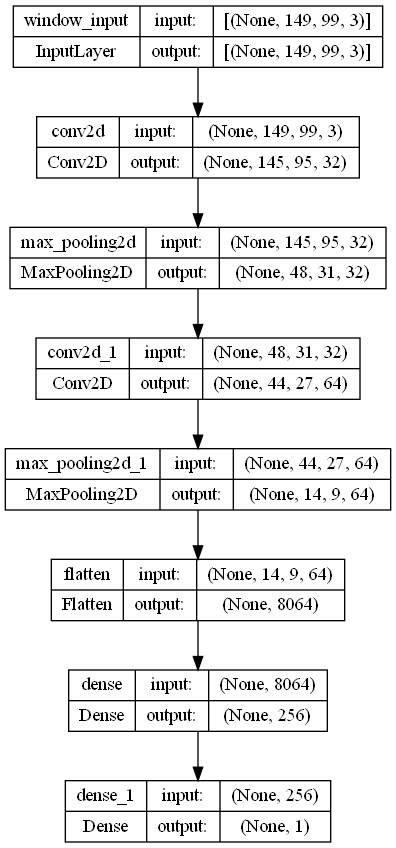

In [12]:
#Plot the structure of whole model
plot_model(model2, show_shapes=True, show_layer_names=True)

In [13]:
#fit the data into model
history2 = model2.fit(x= train_generator, epochs=5, verbose=1, validation_data = vali_generator)

Epoch 1/5
19/19 [==============================] - 3s 113ms/step - loss: 1669.8851 - val_loss: 1803.2494
Epoch 2/5
19/19 [==============================] - 2s 90ms/step - loss: 1411.2053 - val_loss: 2036.3633
Epoch 3/5
19/19 [==============================] - 2s 94ms/step - loss: 1306.6963 - val_loss: 1672.7920
Epoch 4/5
19/19 [==============================] - 2s 88ms/step - loss: 1145.2927 - val_loss: 1385.6251
Epoch 5/5
19/19 [==============================] - 2s 82ms/step - loss: 1165.1831 - val_loss: 1296.4906


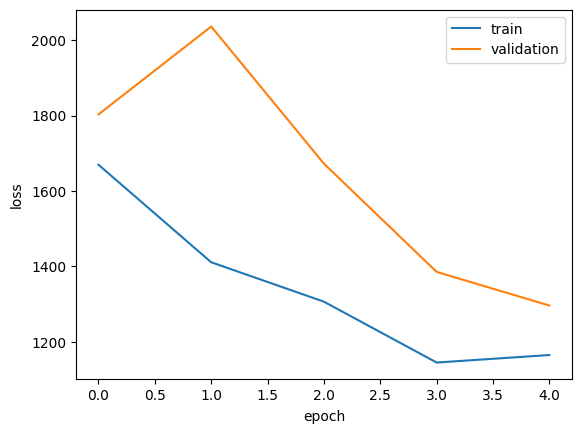

In [14]:
regression_history_plot(history2)

In [15]:
##prepare test data generator
#Load obs predicted as Y
mask = df_test['is_ROI_pred'] == 'Y'
df_test_y = df_test[mask]

#prepare generator
test_gen_spec = image.ImageDataGenerator(rescale=1./255)

test_generator = test_gen_spec.flow_from_dataframe(dataframe=df_test_y,
                                                  directory = test_folder,
                                                  x_col="window_name",
                                                  target_size=(149,99),
                                                  batch_size=1,
                                                  class_mode= None)
test_generator.reset() #reset the generator before putting in, make sure the memory is clear

#make predictions using model trained
start_time = time.time()
pred = model2.predict(x=test_generator, steps = len(df_test_y)) #return a 1D array consist of predicted values
cloud_height_pred = pred.flatten().astype(int) #remove fractions
end_time = time.time()
t_diff2 = end_time - start_time

#write the predicted values
df_pred_result2 = pd.DataFrame({"window_name":df_test_y['window_name'], "y_pred":cloud_height_pred, "y_true":df_test_y["cloud_height"]})
df_pred_result2.to_csv(os.path.join(test_folder,"predicts2.csv"))

print(f"SVM+CNN takes {t_diff1+t_diff2} seconds for predicting the results")

Found 102 validated image filenames.
102/102 [==============================] - 1s 5ms/step
SVM+CNN takes 3.7314400672912598 seconds for predicting the results


The Mean square error of model 2 is 5016.725
Check the 10 largest errors are  
                   window_name  y_pred  y_true  pred_error
103  20231120-154755N_1_3.jpg      39     200         161
93   20231120-154755N_0_1.jpg      41     200         159
144           21-IR-N_0_6.jpg      42     200         158
69    1310-HDR_normal_2_5.jpg      43     200         157
163            6-IR-N_0_7.jpg      43     200         157
89   20231120-154428N_2_5.jpg      44     200         156


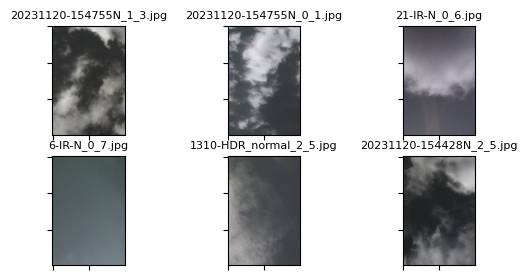

'\nThe MSE of this model is 5527 (approximately 74, still far from being precise)\nAbout the model\n1.As this model was trained on a segmented group of obs., performence of which improved on predicting low level cloud.\n2.However, the error of predicting those high cloud was not learn.\n\nThis model can be further imporved from 2 aspect.\n1.Improved SVM model. If classification process can reach aound 90% of accuracy, it would be worthy to adapt this stacked model.\nAnd ignore those wrongly predicted as METAR has a precision of just 1/8\n\n2.Develop 2 models for predicted-Y and predicted-N group. But this takes double of time. \n\n3.Collect enough data and add more filters on CNN to learn the features.\n'

In [16]:
# #Examinate the second result

#1. calculate MSE
model2_mse = np.square(np.subtract(df_pred_result2['y_true'],df_pred_result2['y_pred'])).mean() #MSE = (1/n)*Sigma(y_true-y_pred)^2
print(f'The Mean square error of model 2 is {round(model2_mse,3)}')

#2. check 10 images of largest prediction error
df_pred_result2['pred_error'] = np.subtract(df_pred_result2['y_true'],df_pred_result2['y_pred']).abs()
print("Check the 10 largest errors are \n",df_pred_result2.nlargest(6,'pred_error'))

#check photos
df_pred_result2.sort_values("pred_error",axis = 0, ascending =False, inplace =True)
index = df_pred_result2.index

for i in range(6):
    img = cv2.imread(os.path.join(test_folder,df_pred_result2['window_name'][index[i]]))
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(df_pred_result2['window_name'][index[i]],fontsize=8)
    plt.xticks(visible=False)
    plt.yticks(visible=False)
plt.show()

'''
The MSE of this model is 5527 (approximately 74, still far from being precise)
About the model
1.As this model was trained on a segmented group of obs., performence of which improved on predicting low level cloud.
2.However, the error of predicting those high cloud was not learn.

This model can be further imporved from 2 aspect.
1.Improved SVM model. If classification process can reach aound 90% of accuracy, it would be worthy to adapt this stacked model.
And ignore those wrongly predicted as METAR has a precision of just 1/8

2.Develop 2 models for predicted-Y and predicted-N group. But this takes double of time. 

3.Collect enough data and add more filters on CNN to learn the features.
'''